In [1]:
%matplotlib widget
import numpy as np
from pylab import*
import matplotlib.pyplot as plt
from qutip import *
import qutip
import scipy
import random
from tqdm import tqdm

In [2]:
def bareIntHamiltonian(N, Jx, Jy, Jz):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = 0
    
    for n in range(N-1):
        H +=  0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
        H +=  0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
        H +=  0.5 * Jz[n] * sz_list[n] * sz_list[n+1] 

    return H, sx_list, sy_list, sz_list



def pulseState(N, H, psi, h, phi, sx_list, sy_list):
    
    for n in range(N):
        H +=  0.5 * h[n] * (np.cos(phi) * sx_list[n] + np.sin(phi) * sy_list[n])    
    # test time pi/2-pulse    
    tlist = linspace(0, np.pi/(2 * abs(h[0])), 50)
    return mesolve(H, psi, tlist).states[-1]
    
def pulseState_pi(N, H, psi, h, phi, sx_list, sy_list):

    for n in range(N):
        H +=  0.5 * h[n] * (np.cos(phi) * sx_list[n] + np.sin(phi) * sy_list[n])    
    # test time pi-pulse
    tlist = linspace(0, np.pi/(1 * abs(h[0])), 100)
    return mesolve(H, psi, tlist).states[-1]

def dynamics_nodrive(N,psi0, tlist, H, sx_list, sy_list, sz_list):
    op_exp = sx_list
    states = mesolve(H, psi0, tlist).states
    exp_val = []
    for i in states:
        exp_val.append(sum(expect(op_exp,i))/N)
    return exp_val, states[-1]


def dynamics_WHH(N,n,psi0,psi_init ,h,phi_list,H, sx_list, sy_list, sz_list, Hint,tlist):
    
    Hint = H * Hint
    op_exp = sx_list
    exp_val = []
    
    exp_val.append(sum(expect(op_exp,psi0))/N)
    #f_list = [np.abs(psi0.overlap(psi_init))**2]
    for i in tqdm(range(n)):
            state1 = mesolve(H, psi0, tlist[0]).states[-1] 
            state2 = pulseState(N, Hint, state1, h, phi_list[0], sx_list, sy_list)
            state3 = mesolve(H, state2, tlist[1]).states[-1]
            state4 = pulseState(N, Hint, state3, h, phi_list[1], sx_list, sy_list)
            state5 = mesolve(H, state4, tlist[2]).states[-1]
            state6 = pulseState(N, Hint, state5, h, phi_list[2], sx_list, sy_list)
            state7 = mesolve(H, state6, tlist[1]).states[-1]
            state8 = pulseState(N, Hint, state7, h, phi_list[3], sx_list, sy_list)
            result = mesolve(H, state8, tlist[0]).states[-1]
            psi0 = result
            exp_val.append(sum(expect(op_exp,psi0))/N)
            #f_list.append(np.abs(psi0.overlap(psi_init))**2)
    fid = np.abs(psi0.overlap(psi_init))**2

    return exp_val, fid#, f_list


def dynamics_trev4(N,n,psi0,psi_init,h,h2 ,phi_list, H, sx_list, sy_list, sz_list, Hint):
    
    Hint = H * Hint
    op_exp = sx_list
    exp_val = []
    exp_val_i = []
    exp_val.append(sum(expect(op_exp,psi0))/N)
    #f_list = [np.abs(psi0.overlap(psi_init))**2]
    for i in tqdm(range(n)):
            #state1 = mesolve(H, psi0, tlist[0]).states[-1] 
            state1 = pulseState(N, Hint, psi0, h, phi_list[0], sx_list, sy_list)
            state2 = pulseState_pi(N, H, state1, h2, phi_list[1], sx_list, sy_list)
            state3 = pulseState_pi(N, H, state2, h2, phi_list[2], sx_list, sy_list)
            result = pulseState(N, Hint, state3, h, phi_list[3], sx_list, sy_list)
            
            psi0 = result
            exp_val.append(sum(expect(op_exp,psi0))/N)
            #exp_val_i.append(expect(op_exp,psi0))
            #f_list.append(np.abs(psi0.overlap(psi_init))**2)
    fid = np.abs(psi0.overlap(psi_init))**2
        
    return exp_val, fid#, f_list#, exp_val_i, op_exp

In [45]:
t_decay = 1.2
N = 4 # particle
n = 100 # n sequences
# intial state: all x
psi_list = [] 
for i in range(N):
     psi_list.append(1/np.sqrt(2) * (basis(2,0)+1*basis(2,1)))
#     psi_list.append((basis(2,0))
psi0 = tensor(psi_list)

h_field = 300 #pi/2 pulses
h_field2 = 1/(2*t_decay) * n # pi pulse strength for trev4 sequence

Jz = -2 * 2 * np.pi * np.ones(N)
Jx = 1 * 2 * np.pi * np.ones(N)
Jy = 1 * 2 * np.pi * np.ones(N)

h  = h_field * 2 * np.pi * np.ones(N)
h2 = h_field2 * 2 * np.pi * np.ones(N)

Hint = 0 # interaction on/off during pi/2-pulses
phi_list = [np.pi,np.pi/2,-np.pi/2,0] # phases of pulses : -x, y, -y, x 


tau =  t_decay/n #devide tdecay time in n sequences

t01,t02,t03 = tau/2, tau, tau #calculate taus for each sequence n

#time during the pulses
t1 = np.linspace(0,t01,5)
t2 = np.linspace(0,t02,5)
t3 = np.linspace(0,2*t03, 10)
tlist = [t1,t2,t3]

#decay time total
ttot = np.linspace(0,t_decay,200)

H, sx_list, sy_list, sz_list = bareIntHamiltonian(N, Jx, Jy, Jz)

#get decayed state psi_start for reversal
exp_v_nodrive , psi_start = dynamics_nodrive(N, psi0, ttot, H, sx_list, sy_list, sz_list)

#start reversal sequences with psi_start
#exp_v_drive, fid = dynamics_trev4(N,n,psi_start,psi0,h,h2,phi_list, H, sx_list, sy_list, sz_list, Hint)
exp_v_drive, fid = dynamics_WHH(N,n,psi_start,psi0 ,h,phi_list,H, sx_list, sy_list, sz_list, Hint,tlist)

100%|██████████| 100/100 [00:02<00:00, 36.07it/s]


In [46]:
t01,t02,2 *t03

(0.006, 0.012, 0.024)

0.8788122181502814


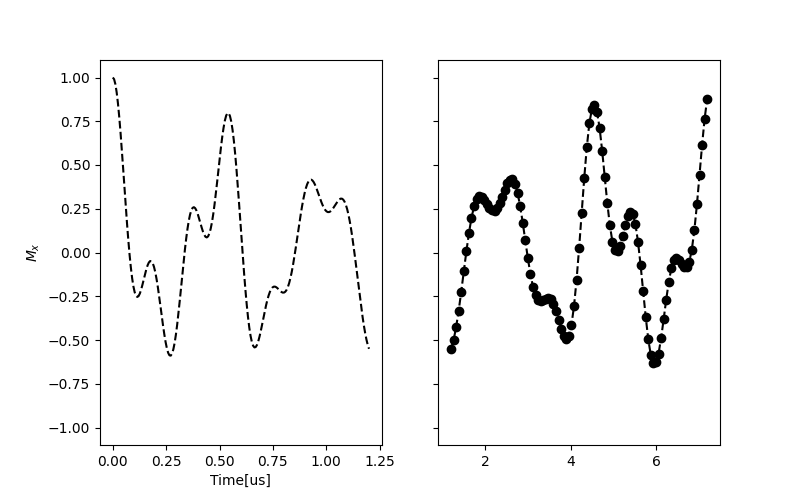

In [47]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8, 5))

ax1.plot(ttot,exp_v_nodrive,'k--',alpha = 1)
ax2.plot(np.arange(n+1)*((t01+t02+t03)*2)+t_decay,exp_v_drive,'k--o',alpha = 1)
ax1.set_ylabel('$M_x$')
ax1.set_xlabel('Time[us]')
ax2.set_ylim(-1.1,1.1)
print(fid)